In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy

In [ ]:
!git clone https://github.com/prajnasb/observations

fatal: destination path 'observations' already exists and is not an empty directory.


In [ ]:
!ls observations/experiements/dest_folder/

test  test.csv	train  train.csv  val


### Creating image datasets an data loaders for train and test using the experiments folder split

In [ ]:
experiments_path = 'observations/experiements/dest_folder/'
data_path = 'observations/experiements/data/'

In [ ]:
'''
transforms.RandomResizedCrop(224): This will extract a patch of size (224, 224) from your input image randomly. So, it might pick this path from topleft, bottomright or anywhere in between. So, you are doing data augmentation in this part. Also, changing this value won't play nice with the fully-connected layers in your model, so not advised to change this.
transforms.ToTensor(): This just converts your input image to PyTorch tensor.
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): This is just input data scaling and these values (mean and std) must have been precomputed for your dataset. Changing these values is also not advised.
transforms.CentreCrop(224): Crops the center part of the image of shape (224, 224)
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# New Section

In [ ]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
    file_path = os.path.join(experiments_path, file_name)
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for (idx, row) in train_df.iterrows():
        files_path.append(os.path.join(data_path, row['class'], row['filename']))
        fonts_class.append(row['class'])
    
    return files_path, fonts_class

In [ ]:
def copy_images_to_path(file_path, file_class, destination_dir):
    font_folder = os.path.join(destination_dir, file_class)
    if os.path.exists(font_folder) == False:
        os.makedirs(font_folder)
    
    print("File being copied from {}:{}".format(file_path, font_folder))
    shutil.copy(file_path, font_folder)
    #shutil.copyfile(file_path, font_folder)
    

In [ ]:
X_train, y_train = get_train_files_path(experiments_path, data_path, phase='train')
X_test, y_test = get_train_files_path(experiments_path, data_path, phase='test')

In [ ]:
train_dir = os.path.join(experiments_path, 'train')
test_dir = os.path.join(experiments_path, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [ ]:
for file_path, font_class in zip(X_train, y_train):
    copy_images_to_path(file_path, font_class, train_dir)

File being copied from observations/experiements/data/with_mask/0-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/10-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/100-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/101-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/103-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/104-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/105-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/da

In [ ]:
for file_path, font_class in zip(X_test, y_test):
    copy_images_to_path(file_path, font_class, test_dir)

File being copied from observations/experiements/data/with_mask/1-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/106-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/11-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/110-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/111-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/114-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/121-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [ ]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1315
    Root location: observations/experiements/dest_folder/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 194
    Root location: observations/experiements/dest_folder/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fcab6e29d90>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fcab854b350>}

In [ ]:
class_names = image_datasets['train'].classes

In [ ]:
class_names

['with_mask', 'without_mask']

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}


### Visualizing images

In [ ]:
def imshow(inp, title=None):
  
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(5,5))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


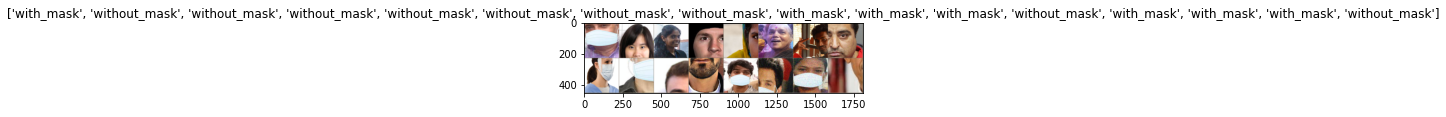

In [ ]:
imshow(out, title=[class_names[x] for x in classes])

### Training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model

In [ ]:
# import ssl


In [ ]:
# ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
print("in_features:", num_frts, len(class_names))
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

in_features: 2048 2


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.1927 Acc:0.9133

test Loss: 0.0153 Acc:0.9948

Epoch 1/19
----------
train Loss: 0.1264 Acc:0.9407

test Loss: 0.0131 Acc:0.9948

Epoch 2/19
----------
train Loss: 0.0775 Acc:0.9734

test Loss: 0.0095 Acc:0.9948

Epoch 3/19
----------
train Loss: 0.0871 Acc:0.9612

test Loss: 0.0058 Acc:1.0000

Epoch 4/19
----------
train Loss: 0.0805 Acc:0.9650

test Loss: 0.0016 Acc:1.0000

Epoch 5/19
----------
train Loss: 0.0706 Acc:0.9643

test Loss: 0.0025 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.0703 Acc:0.9635

test Loss: 0.0018 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.0607 Acc:0.9688

test Loss: 0.0012 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0662 Acc:0.9673

test Loss: 0.0008 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0612 Acc:0.9741

test Loss: 0.0010 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.0668 Acc:0.9673

test Loss: 0.0008 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0687 Acc:0.9612

test Loss: 0.0006 Acc:1.0000

Epoch 12/19
----------
t

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(10,10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                #ax = plt.subplot(num_images//len(labels)-1, len(labels), images_so_far)
                #ax.axis('off')
                #ax.set_title('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                print('\n\n\ntrue: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
torch.save(model_ft, 'mask1_model_resnet101.pth')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0') predicitons



true: with_mask predicted: with_mask


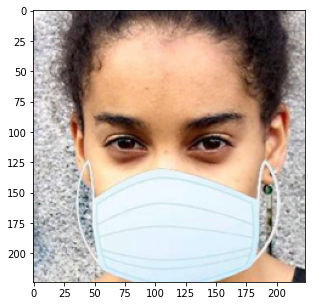




true: with_mask predicted: with_mask


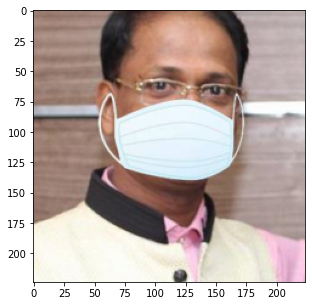




true: with_mask predicted: with_mask


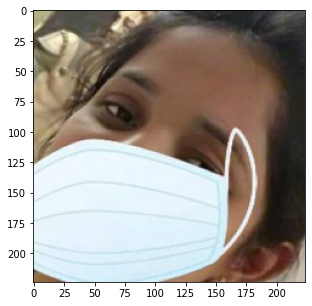




true: without_mask predicted: without_mask


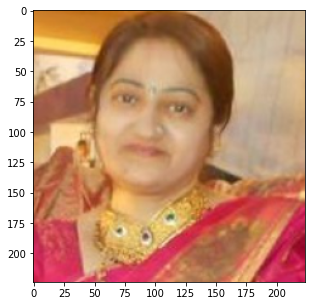




true: without_mask predicted: without_mask


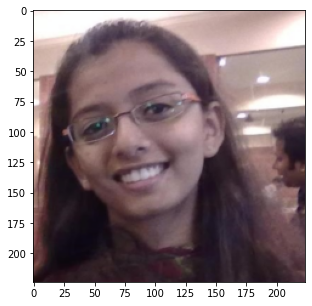




true: without_mask predicted: without_mask


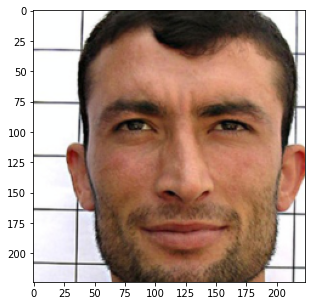

In [ ]:
visualize_model(model_ft)